## Compare family group similarity between different models
* Generate violin plots showing inter-subject similarity for unrelated, sibling, DZ/MZ twins, and self-retest
* Compare the separability of these distributions between models
    * eg: How separable are unrelated and siblings for latent, is that significantly more separable than for observed connetcomes?

In [1]:
import os
import numpy as np
from scipy.io import loadmat
import pandas as pd
from matplotlib import pyplot as plt

from utils import timestamp, krakendir
from data import load_study_data, get_family_level_dict
from predict import *
from plotting import crop_background, plot_family_similarity_violins

from family_group_stats import *

output_dir=krakendir()+'/demographic_prediction_figures'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir,exist_ok=True)

Added /Users/kwj5/Source/krakencoder to path


/Users/kwj5/Research/krakencoder/hcp_20230927_012518_ep002000_retest_mse.w1000_encoded.mat
/Users/kwj5/Research/krakencoder/hcp_20230927_012518_ep002000_mse.w1000_encoded.mat
Computing latent subject corr similarity AFTER averaging flavors
enc_mean=998x128 -> Xsim=998x998
0 0 encFC latent nan
1 0 encFC latent nan
2 0 encFC latent nan
3 0 encFC latent nan
5 0 encFC latent nan
2 1 encFC latent nan
3 1 encFC latent nan
5 1 encFC latent nan
3 2 encFC latent nan
5 2 encFC latent nan
5 3 encFC latent nan
0 0 encFC raw nan
1 0 encFC raw nan
2 0 encFC raw nan
3 0 encFC raw nan
5 0 encFC raw nan
2 1 encFC raw nan
3 1 encFC raw nan
5 1 encFC raw nan
3 2 encFC raw nan
5 2 encFC raw nan
5 3 encFC raw nan
latent: latent=corr , raw: raw=corr
latent: latent=corr , raw: raw=corr
latent: latent=corr , raw: raw=corr
latent: latent=corr , raw: raw=corr
latent: latent=corr , raw: raw=corr
latent: latent=corr , raw: raw=corr
latent: latent=corr , raw: raw=corr
latent: latent=corr , raw: raw=corr
latent: la

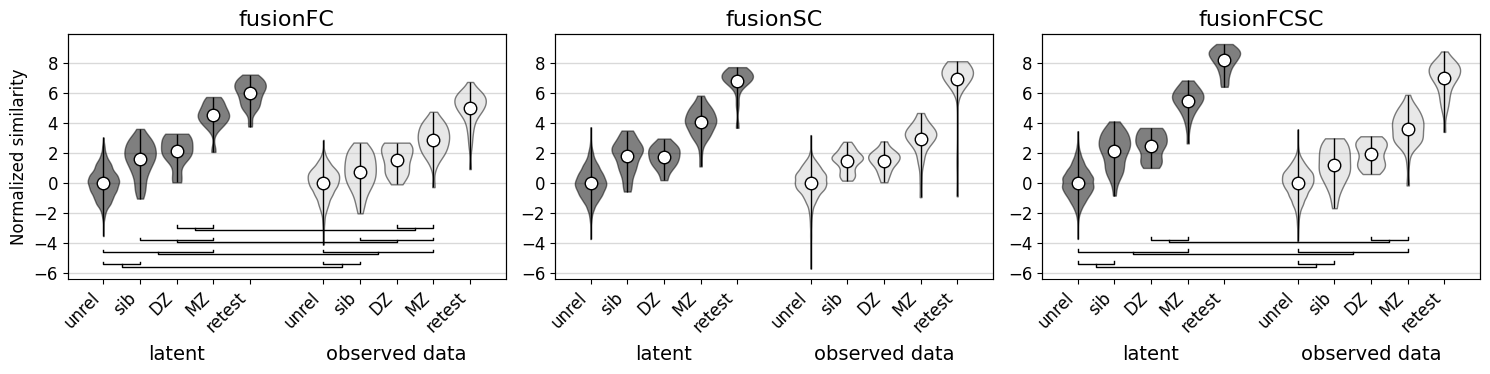

In [2]:
# family similarity violins for all studies

timestamp_str=timestamp()

whichstudy='HCP'
#whichstudy='HCPDev'
#whichstudy='HCPAging'

exclude_str=None
#exclude_str='gsr'

#this is for finding unrelated subjects that match a subject's sibling (for stat='list')
listcompare_max_agediff=1
#listcompare_max_agediff=3

unrelated_nonsibling_match=False
normalize_similarity=True
#this is for selecting which pairs can be used for the violin plot
violin_max_agediff=3
violin_samesex=True

famlevel_dict=get_family_level_dict()
#{'unrelated': 0, 'sibling': 1, 'DZ': 2, 'MZ': 3, 'self': 4, 'retest': 5}

stat_test_type='roc'
#auc_pval_nsamples=10000
auc_pval_nsamples=1000 #(use this)
#auc_pval_nsamples=100
#auc_pval_nsamples=10
#auc_pval_nsamples=2 #for testing

#save the stats after we compute them, so we don't necessarily need to recompute 
# all the permutations just for modifying some display feature

use_stat_list_timestamp=None
#use_stat_list_timestamp='20231207-152234'

#use_stat_list_timestamp='20231211-105445'

pval_test_info={'threshold':.05, 'corrected': True, 'correction_group':'flavor', 'correction_method':'fdr_bh'}

if whichstudy=='HCP':
    famlevels=[famlevel_dict['unrelated'], famlevel_dict['sibling'], famlevel_dict['DZ'], famlevel_dict['MZ'], famlevel_dict['retest']]
    load_retest=True
else:
    famlevels=[famlevel_dict['unrelated'], famlevel_dict['sibling']]
    load_retest=False
    
    violin_max_agediff=np.inf
    violin_samesex=False
    unrelated_nonsibling_match=True
    stat_test_type='sibling_list'
    pval_test_info={'threshold':.01, 'corrected': True, 'correction_group':None, 'correction_method':'fdr_bh'}

#conntypes,_=flavor_reorder([canonical_data_flavor(c) for c in get_hcp_data_flavors(fc_filter_list=['hpf'])], pcorr_at_end=False, sort_atlas_last=True)
conntypes=['encFC','encSC','encFCSC']

#stat_list_log=[] #reset stat_list_log
try:
    stat_len=len(stat_list_log)
except:
    stat_list_log=[]

######################################
df_fam_performance=pd.DataFrame()
stat_list=[]

#rawdata: cosine and corr basically indistinguishable
#rawdatasim='corr_resid' #only for predicted data
#corr works better than cosine for latent similarity

#latent_or_raw_list=['latent=corr','raw=corr','pred=corr_resid']
#latent_or_raw_list=['latent=corr','raw=cosine']
#latent_or_raw_list=['latent=corr.post','raw=corr']
latent_or_raw_list=['latent=corr','raw=corr']

for iconn,conntype in enumerate(conntypes):
    for isim, rawpredsim in enumerate(latent_or_raw_list):
        
        Data = load_study_data(studyname=whichstudy,combine_type='mean', latent_or_raw_spec=rawpredsim, exclude_flavor_string=exclude_str, retest=load_retest)
        
        df_famsim = get_family_data_similarity(Data, input_flavor=conntype, famlevels=famlevels, listcompare_max_agediff=listcompare_max_agediff, stat_test_type=stat_test_type,
                                normalize_similarity=normalize_similarity, violin_max_agediff=violin_max_agediff, violin_samesex=violin_samesex)
        
        df_fam_performance=pd.concat((df_fam_performance,df_famsim),ignore_index=True)
        
    statlist_tmp=compare_family_data_similarity(df_fam_performance, input_flavor=conntype, famlevels=famlevels, stat_test_type=stat_test_type, auc_pval_nsamples=auc_pval_nsamples)
    stat_list+=statlist_tmp
    
if use_stat_list_timestamp is not None:
    istat=[i for i,v in enumerate(stat_list_log) if v['timestamp']==use_stat_list_timestamp]
    assert len(istat)>0, "Could not find stat list with timestamp %s" % (use_stat_list_timestamp)
    if len(istat)>0:
        istat=istat[0]
        stat_list=stat_list_log[istat]['stat_list'].copy()
        print("#########################################")
        print("#########################################")
        print("Using saved stat list %d/%d: %s" % (istat,len(stat_list_log),use_stat_list_timestamp))
        print("#########################################")
        print("#########################################")

stat_list = correct_family_similarity_pvals(stat_list, pval_test_info, input_flavors=conntypes)

stat_list_log.append({'stat_list':stat_list.copy(),'timestamp':timestamp()})

fig=plot_family_similarity_violins(df_fam_performance=df_fam_performance, conntypes=conntypes, stat_list=stat_list, famlevels=famlevels,
                        pval_test_info=pval_test_info, normalize_similarity=normalize_similarity, unrelated_nonsibling_match=unrelated_nonsibling_match,
                        violin_max_agediff=violin_max_agediff, violin_samesex=violin_samesex, figdpi=100)

#outimg=os.path.join(output_dir,"%s_family_structure.png" % (whichstudy.lower()))
#fig.savefig(outimg,dpi=300)
#_=crop_background(outimg,outfile="same")